<a href="https://colab.research.google.com/github/rkurdyumov/control_challenges/blob/main/inverted_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook derives an LQR controller for the inverted pendulum on a cart problem found at:

https://janismac.github.io/ControlChallenges/

The basic approach is to re-simulate the full non-linear system in this notebook and quickly tune the controller here.

In [ ]:
!pip install slycot   # Install python-control dependencies for Colab.
!pip install control

In [4]:
import control
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [27]:
# Inverted pendulum parameters, taken from:
# https://github.com/janismac/ControlChallenges/blob/gh-pages/js/models/SinglePendulum.js
m0 = 10.0 # cart mass (kg)
m1 = 0.5  # pendulum mass (kg)
g = 9.81  # (m/s^2)
L = 1.0   # pendulum length (m)
z0 = [-2.0, 0.0, 0.2, 0.0]  # initial [x0, dx0, theta, dtheta]
    
def wrap_angle(theta):
  # Returns theta wrapped to [-pi, pi)
  return (theta + np.pi) % (2 * np.pi) - np.pi

def dz_dt(t, z, K):
  # State update dz/dt for z = [x0, dx0, theta, dtheta].
  # The equations of motion are simplified from equations (3) and (6):
  # https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling
  # where I = 0 and our theta = (pi - their_theta).
  #   (m0 + m1)*ddx0 + m1*L*cos(theta)*ddtheta - m1*L*dtheta^2*sin(theta) = F
  #   L*ddtheta + cos(theta) * ddx0 = g*sin(theta)
  # We have a system of equations Ax=b, where x = [ddx0, ddtheta].
  x0, dx0, theta, dtheta = z
  # Apply state feedback u = -Kz.
  F = 0 if K is None else np.dot(-K, [x0, dx0, wrap_angle(theta), dtheta])
  A = np.array([
      [m0 + m1,       m1*L*np.cos(theta)],
      [np.cos(theta), L]])
  b = np.array([F + m1*L*np.sin(theta)*dtheta**2, g*np.sin(theta)])
  ddx0, ddtheta = np.linalg.solve(A,b)
  return [dx0, ddx0, dtheta, ddtheta]

# State space representation of the inverted pendulum on a cart, linearized
# about the upright state (a similarly simplified equation (20) from the link
# above).
A = np.array([
    [0, 1,  0,               0],
    [0, 0, -m1*g/m0,  0],
    [0, 0,  0,               1],
    [0, 0, (m0+m1)*g/(m0*L), 0]])
B = np.array([
    [0],
    [1/m0],
    [0],
    [-1/(m0*L)]])
C = np.diag([1, 1, 1, 1]) # Output all states.
D = 0

def settle_time(t, x0, dx0, theta, dtheta):
  # Return the settle time for the cart-pendulum (used to evaluate controllers).
  # These values are taken from:
  # https://github.com/janismac/ControlChallenges/blob/gh-pages/js/levels/StabilizeSinglePendulum.js
  x0_i = np.abs(x0) < 0.01
  dx0_i = np.abs(dx0) < 0.01
  theta_i1 = np.abs(np.sin(theta)) < 0.001
  theta_i2 = np.cos(theta) > 0.999
  dtheta_i = np.abs(dtheta) < 0.01
  all = np.logical_and.reduce((x0_i, dx0_i, theta_i1, theta_i2, dtheta_i))
  t_settle = t[all]
  return t_settle[0] if t_settle.size else -1

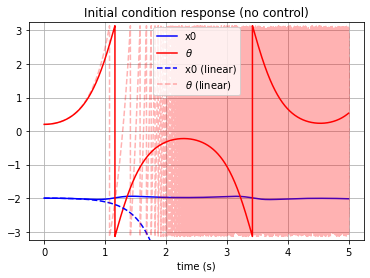

In [104]:
# Verify initial condition response (no control).
# The non-linear sim should have a swinging pendulum and back and forth cart 
# movement.
# The linear sim will behave non-physically.  It should diverge since it is 
# linearized about the upright unstable equilibrium point.

dt = 1e-4
t = np.arange(0, 5, dt)
K = None # No controller.

# Run the non-linear and linear sims and compare.
nonlin = solve_ivp(dz_dt, [t[0], t[-1]], z0, t_eval=t, args=(K,))
x0, dx0, theta, dtheta = nonlin.y
_, y_lin = control.initial_response(control.ss(A, B, C, D), t, z0)
x0_lin, dx0_lin, theta_lin, dtheta_lin = y_lin

plt.plot(t, x0, "b", label="x0")
plt.plot(t, wrap_angle(theta), "r", label=r"$\theta$")
plt.plot(t, x0_lin, "b--", label="x0 (linear)")
plt.plot(t, wrap_angle(theta_lin), "r--", alpha=0.3, label=r"$\theta$ (linear)")
plt.title("Initial condition response (no control)")
plt.xlabel("time (s)")
plt.ylim([-np.pi-0.1, np.pi+0.1])
plt.legend()
plt.grid()

MSE(x0): 0.000030m
MSE(theta): 0.000001rad
settle_time: 3.90s


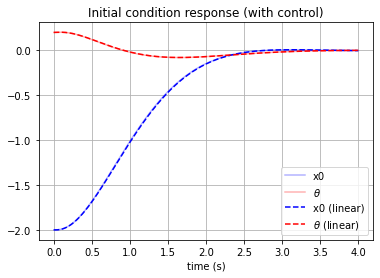

In [129]:
# Verify initial condition response (with control).
# Since the controller will keep the pendulum close to upright, the linear sim
# should stay reasonably accurate.

dt = 1e-4
t = np.arange(0, 4.0, dt)
K = np.array([-110, -160, -1100, -400]) # Sample solution given in challenge.

# Run the non-linear and linear sims and compare.
nonlin = solve_ivp(dz_dt, [t[0], t[-1]], z0, t_eval=t, args=(K,))
x0, dx0, theta, dtheta = nonlin.y
_, y_lin = control.initial_response(control.ss(A-B*K, B, C, D), t, z0)
x0_lin, dx0_lin, theta_lin, dtheta_lin = y_lin

plt.plot(t, x0, "b", alpha=0.3, label="x0")
plt.plot(t, theta, "r", alpha=0.3, label=r"$\theta$")
plt.plot(t, x0_lin, "b--", label="x0 (linear)")
plt.plot(t, theta_lin, "r--", label=r"$\theta$ (linear)")
plt.title("Initial condition response (with control)")
plt.xlabel("time (s)")
plt.legend()
plt.grid()

# There's almost no difference between the linear and non-linear sims when we
# stay upright (close to the linearization point).
mse_x0 = np.power(x0 - x0_lin, 2).mean()
mse_theta = np.power(theta - theta_lin, 2).mean()
print("MSE(x0): {0:.6f}m\nMSE(theta): {1:.6f}rad".format(mse_x0, mse_theta))
print("settle_time: {0:.2f}s".format(settle_time(t, x0, dx0, theta, dtheta)))

Bryson's rule:
K = [ -500.    -857.95 -4871.36 -1624.38]
min(u): -25.73N, max(u): 42.82N
settle_time: -1.00s

Trial and error tuning:
K = [-100.   -120.16 -762.2  -243.63]
min(u): -47.56N, max(u): 54.02N
settle_time: 3.52s


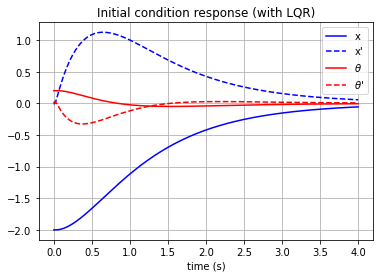

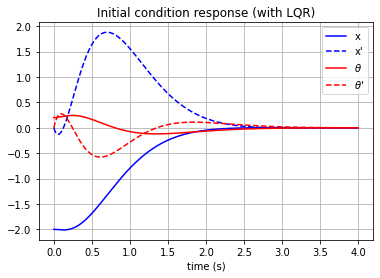

In [130]:
# LQR control
# TODO: Try implementing an MPC controller.

def solve_lqr(t, Q, R):
  K, S, E = control.lqr(A, B, Q, R)
  K = np.asarray(K).flatten()
  np.set_printoptions(precision=2)
  print("K = {}".format(K))
  sol = solve_ivp(dz_dt, [t[0], t[-1]], z0, t_eval=t, args=(K,))
  x0, dx0, theta, dtheta = sol.y
  u = np.dot(-K, sol.y)

  plt.figure()
  plt.plot(t, x0, 'b', label="x")
  plt.plot(t, dx0, 'b--', label="x'")
  plt.plot(t, theta, 'r', label=r"$\theta$")
  plt.plot(t, dtheta, 'r--', label=r"$\theta$'")
  plt.title("Initial condition response (with LQR)")
  plt.legend()
  plt.grid()
  plt.xlabel("time (s)")

  print("min(u): {:.2f}N, max(u): {:.2f}N".format(min(u),max(u)))
  print("settle_time: {:.2f}s".format (settle_time(t, x0, dx0, theta, dtheta)))

dt = 1e-4
t = np.arange(0, 4.0, dt)

print("Bryson's rule:")
# Use Bryson's rule as a first guess at the Q and R values.
# Choose zi_max = 0.1 as an initial guess at max allowable state values.
Q = np.diag([1/0.1**2, 1/0.1**2, 1/0.1**2, 1/0.1**2])  # 1/max(zi^2)
# Fmax = 50N, from:
# https://github.com/janismac/ControlChallenges/blob/gh-pages/js/models/SinglePendulum.js#L33
R = 1/2500 # 1/Fmax^2
solve_lqr(t, Q, R)

print("\nTrial and error tuning:")
# Bryson's rule is too aggressive with theta and not aggressive enough with x.
# Modify the Q and R matrices by trial and error to find a faster controller.
Q = np.diag([10000, 1000, 1000, 1000])  # Trial & error, exceeds Fmax = 50N.
# Leave R as 1 and scale Q to trade off control effort vs error.
R = 1
solve_lqr(t, Q, R)